In [1]:
import itertools
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import seaborn as sns; sns.set()

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")

/Users/evan/.pyenv/versions/3.11.5/envs/de/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [4]:
TARGET_DF = amazon

In [5]:
vwap = TARGET_DF['volume_weighted_average_price']

In [6]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

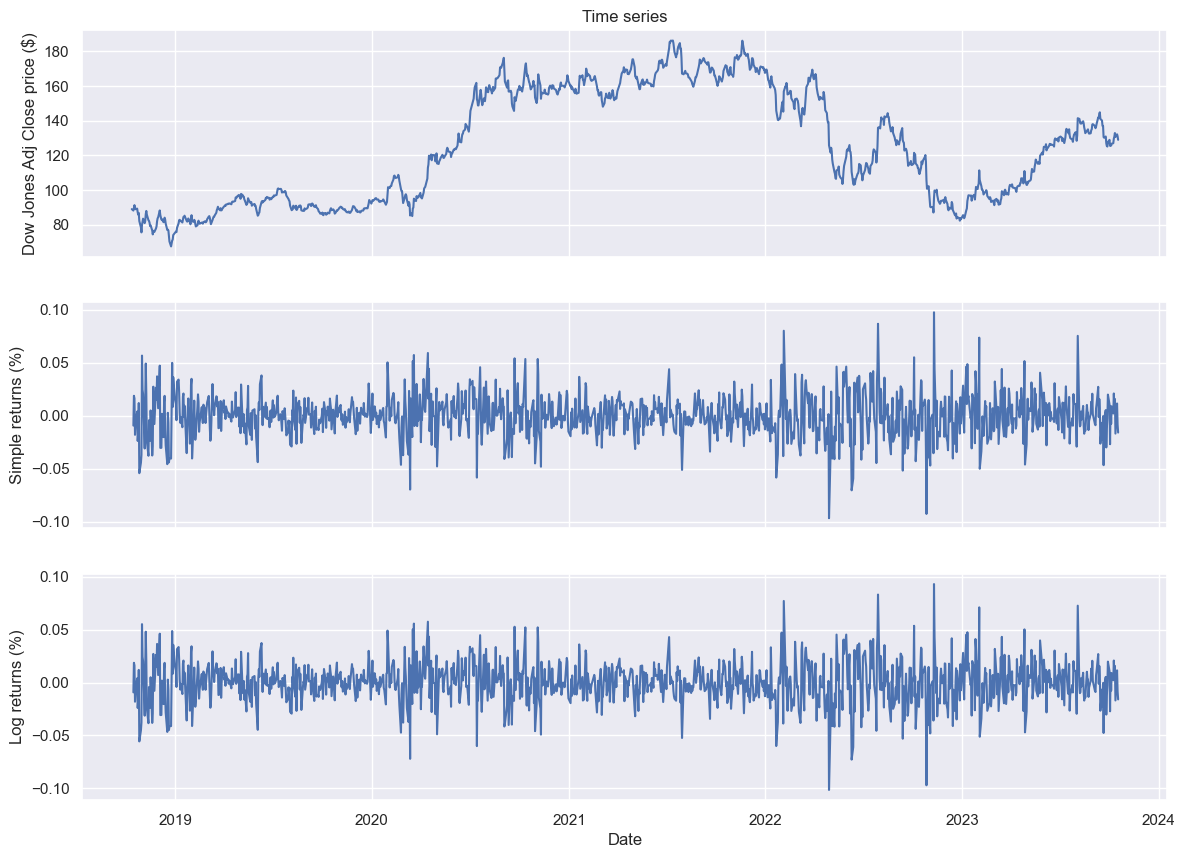

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Dow Jones Adj Close price ($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
TARGET_DF.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show()

In [8]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

19:31:52 - cmdstanpy - INFO - Chain [1] start processing
19:31:52 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds        yhat  yhat_lower  yhat_upper
1622 2024-10-13  156.349977  116.833919  193.336903
1623 2024-10-14  156.586635  115.645728  193.521340
1624 2024-10-15  156.785051  117.835209  193.969138
1625 2024-10-16  156.938173  117.955653  194.609698
1626 2024-10-17  157.040042  119.863666  193.406150


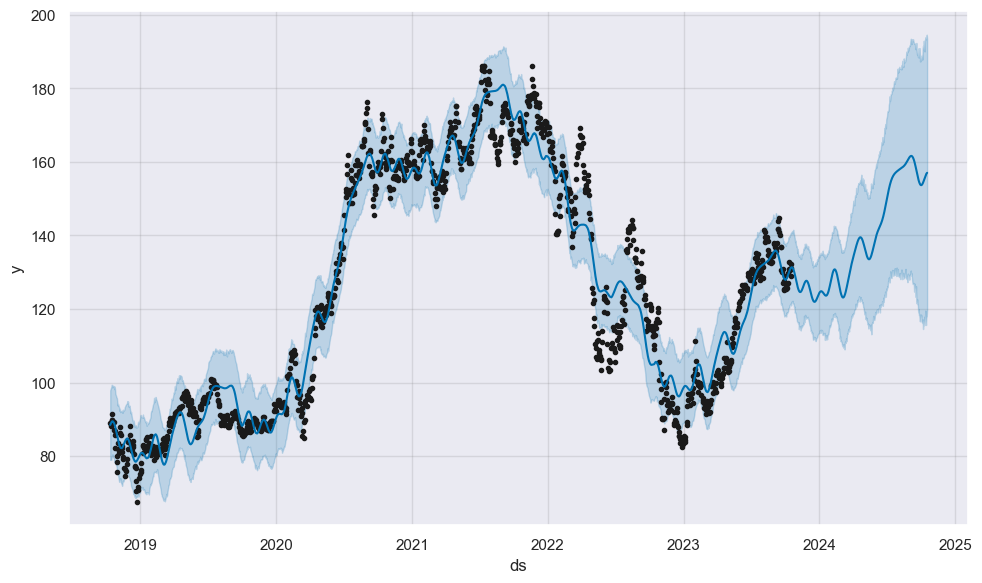

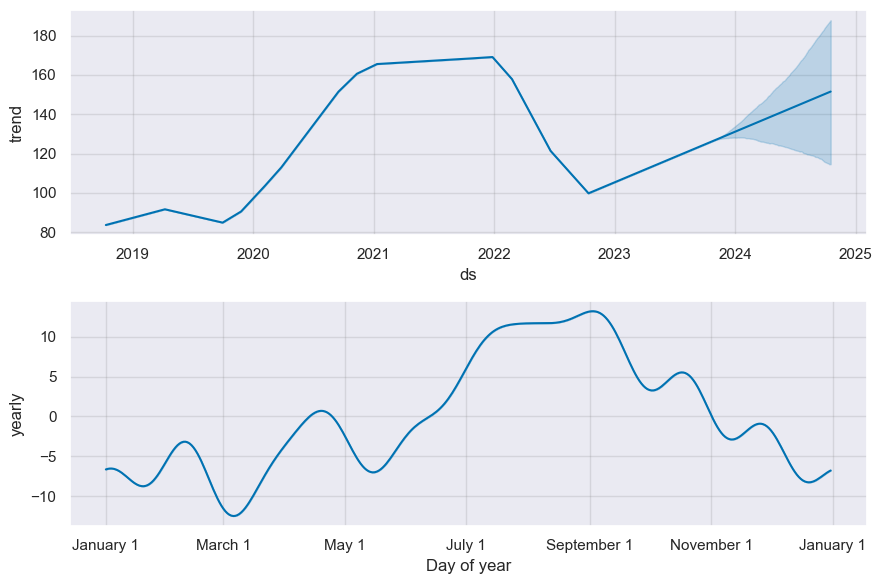

In [22]:
param_grid={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive"
}

m = Prophet(**param_grid)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=92.25, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

fig1 = plot_plotly(m, forecast, figsize=(1000,600)) # 
fig2 = plot_components_plotly(m, forecast, figsize=(1000,600))

In [23]:
df_cv = cross_validation(m, initial='750 days', period='30 days', horizon = '90 days', parallel="processes")

19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [

In [27]:
df_p = performance_metrics(df_cv)
df_p

horizon         mse       rmse        mae      mape     mdape     smape  \
0   9 days  161.040650  12.690179   9.580472  0.076549  0.053672  0.077784   
1  10 days  177.375424  13.318237  10.009017  0.080091  0.054882  0.081405   
2  11 days  185.972912  13.637189  10.356391  0.082721  0.055729  0.084298   
3  12 days  187.965168  13.710039  10.500966  0.083634  0.057040  0.085434   
4  13 days  201.478512  14.194313  10.919669  0.086949  0.058936  0.088354   
..     ...         ...        ...        ...       ...       ...       ...   
77 86 days  775.568594  27.849032  22.219368  0.176839  0.126602  0.184747   
78 87 days  794.576138  28.188227  22.672186  0.180238  0.135818  0.188362   
79 88 days  792.014256  28.142748  22.602862  0.180210  0.135818  0.188737   
80 89 days  774.798026  27.835194  22.271875  0.177394  0.133527  0.185797   
81 90 days  777.311165  27.880301  22.272130  0.176938  0.138504  0.185215   

    coverage  
0   0.459325  
1   0.436025  
2   0.402579  
3   0.376190  
4   0.342650  
..       ...  
77  0.210476  
78  0.203520  
79  0.217460  
80  0.232298  
81  0.238095  

[82 rows x 8 columns]

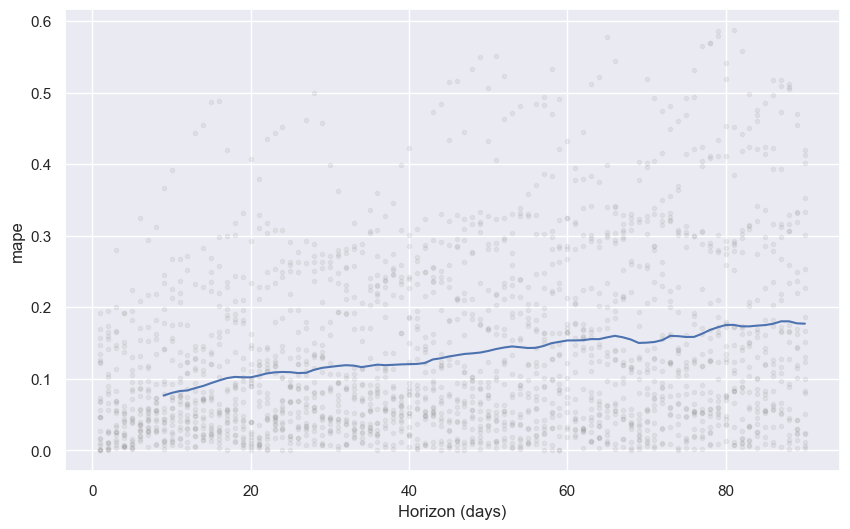

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')